In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter
import cv2

In [10]:

def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = np.clip(X, 0, a.shape[0] - 2)
    Y = np.clip(Y, 0, a.shape[1] - 2)


    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

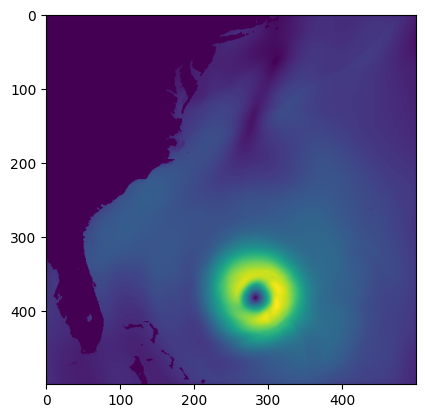

In [11]:
d1 = h5py.File("../isabel_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"])
v = np.array(d1["Velocity"]["Y-comp"])
mag = magnitude2(u, v)
img = np.dstack([u, v, np.zeros_like(u)])
mesh_size = u.shape[0]
visualize(magnitude2(u, v))

In [12]:
# generate noise texture
n = np.random.random(u.shape)

# perform LIC
l = 8_000
h = np.exp(-np.linspace(-8, 8, l)**2)  

h /= h.sum()
kernel_magnitude = sum(h)

In [13]:
i = np.arange(0, mesh_size).astype(float)
j = np.arange(0, mesh_size).astype(float)
ii, jj = np.meshgrid(i, j)

In [14]:
F = np.zeros_like(n)

F = h[0]*interp2d(n, ii, jj)

step_size = 0.005

# fwd
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-6 

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx += dtx
    yy += dty

    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")

# bwd
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-6  

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx -= dtx
    yy -= dty

    F += h[k] * interp2d(n, xx, yy)
    print(f"{k}/{l}")


1/8000
2/8000
3/8000
4/8000
5/8000
6/8000
7/8000
8/8000
9/8000
10/8000
11/8000
12/8000
13/8000
14/8000
15/8000
16/8000
17/8000
18/8000
19/8000
20/8000
21/8000
22/8000
23/8000
24/8000
25/8000
26/8000
27/8000
28/8000
29/8000
30/8000
31/8000
32/8000
33/8000
34/8000
35/8000
36/8000
37/8000
38/8000
39/8000
40/8000
41/8000
42/8000
43/8000
44/8000
45/8000
46/8000
47/8000
48/8000
49/8000
50/8000
51/8000
52/8000
53/8000
54/8000
55/8000
56/8000
57/8000
58/8000
59/8000
60/8000
61/8000
62/8000
63/8000
64/8000
65/8000
66/8000
67/8000
68/8000
69/8000
70/8000
71/8000
72/8000
73/8000
74/8000
75/8000
76/8000
77/8000
78/8000
79/8000
80/8000
81/8000
82/8000
83/8000
84/8000
85/8000
86/8000
87/8000
88/8000
89/8000
90/8000
91/8000
92/8000
93/8000
94/8000
95/8000
96/8000
97/8000
98/8000
99/8000
100/8000
101/8000
102/8000
103/8000
104/8000
105/8000
106/8000
107/8000
108/8000
109/8000
110/8000
111/8000
112/8000
113/8000
114/8000
115/8000
116/8000
117/8000
118/8000
119/8000
120/8000
121/8000
122/8000
123/8000
1

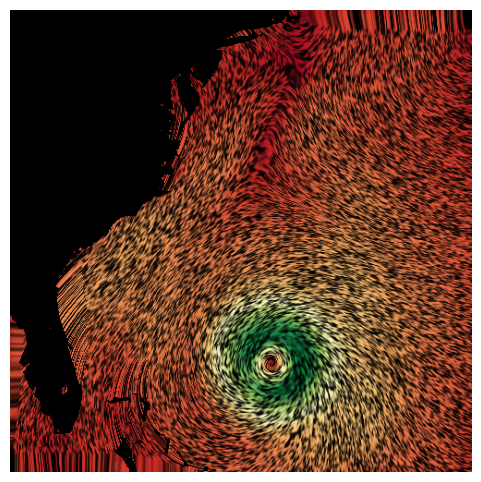

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor("black")
ax.set_axis_off()

# normalize lic result
F_proc = np.copy(F.T)
F_proc[mag < 0.01] = 0.0
F_proc -= F_proc.min()
F_proc /= F_proc.max()

# Apply histogram equalization
F_eq = np.copy(F_proc)
F_eq *= 255
F_eq = F_eq.astype(np.uint8)
F_eq = cv2.equalizeHist(F_eq)
F_eq = (F_eq/255.0).astype(np.float32)

mag_proc = np.copy(mag)
mag_proc -= mag_proc.min()
mag_proc /= mag_proc.max()

cmap = plt.cm.RdYlGn(mag_proc)

cmap[..., :3] *= F_eq[..., np.newaxis]
plt.imshow(cmap, cmap='grey')

plt.show()